In [217]:
import pandas as pd
import config as c
import postgres as p
from main import connect_db

import warnings
warnings.filterwarnings('ignore')
from pandasql import sqldf
from main import sql
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sql = lambda q: sqldf(q, globals())


Connecting to the database and selecting some columns to a dataframe.

In [218]:
con = connect_db(host_name = c.HOST_NAME, dbname=c.DBNAME, port=c.PORT, 
                      username=c.USERNAME, password= c.PASSWORD)
curr = con.cursor() 

Connected!


In [219]:

string = """ 
    SELECT country_code, country, sub_region,
                    intermediate_region,
                    household_net_wealth, 
                    personal_earnings, 
                    quality_support_network,mg_m3, 
                    water_quality_percentage,
                    life_expectancy, student_scores, 
                    leisure_time, life_satisfaction_score, 
                    value as govt_trust
    FROM happiness 
    """


df = pd.read_sql(string, con,)

df.head()


,country_code,country,sub_region,intermediate_region,household_net_wealth,personal_earnings,quality_support_network,mg_m3,water_quality_percentage,life_expectancy,student_scores,leisure_time,life_satisfaction_score,govt_trust
0,AUS,Australia,Oceania,Australia and New Zealand,528768.0,55206.0,93.0,6.7,92.0,83.0,499.0,14.360,7.1,51.922638
1,AUT,Austria,Europe,Western Europe,309637.0,53132.0,92.0,12.2,92.0,82.0,491.0,14.510,7.2,61.045895
2,BEL,Belgium,Europe,Western Europe,447607.0,54327.0,90.0,12.8,79.0,82.1,500.0,15.520,6.8,47.313310
3,CAN,Canada,Americas,Northern America,478240.0,55342.0,93.0,7.1,90.0,82.1,517.0,14.570,7.0,61.041120
4,CHL,Chile,Americas,Latin America and the Caribbean,135787.0,26729.0,88.0,23.4,62.0,80.6,438.0,14.974,6.2,23.214481


In [220]:
#How many countries in each region?
sql(
    """
    SELECT d.sub_region as 'Region', count(1) as 'Number of countries'

    FROM df as d
    GROUP BY d.sub_region;    
    """)

,Region,Number of countries
0,Africa,1
1,Americas,7
2,Asia,4
3,Europe,27
4,Oceania,2


In [221]:
#Countries group by household net wealth
sql("""
    SELECT country as Country, household_net_wealth as 'Household Net wealth'
    FROM df
    ORDER BY household_net_wealth DESC
    LIMIT 5;

""")

,Country,Household Net wealth
0,Luxembourg,941162.0
1,United States,684500.0
2,Australia,528768.0
3,United Kingdom,524422.0
4,New Zealand,514162.0


It is noticable that **Luxembourg** is ahead of the other countries. Let's create a bar chart to compare Luxembourg against the other European countries.


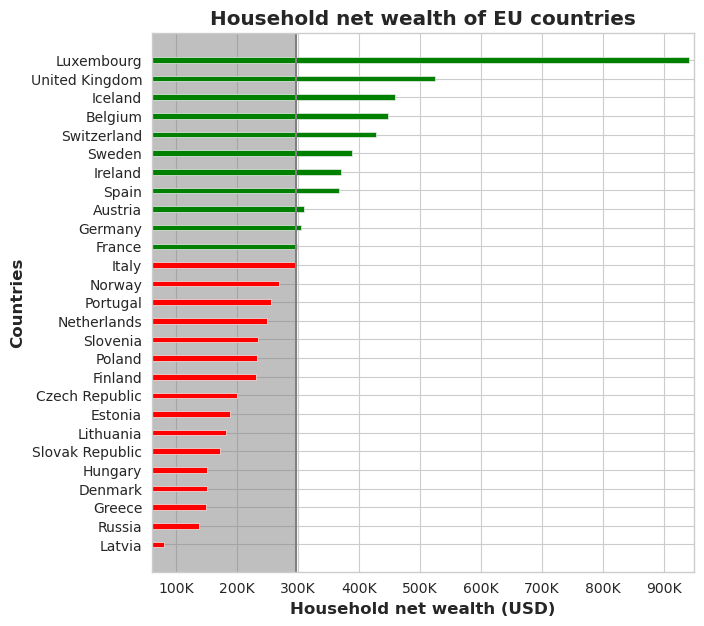

In [222]:
#Comparison of european countries
df_compare_eusubregion = sql(
    """
    SELECT d.country, d.household_net_wealth as household_net_wealth,
    (select round(avg(household_net_wealth),0) from df as e where e.sub_region = d.sub_region) as sub_region_avg
    FROM df as d
    where d.sub_region = 'Europe'
    order by household_net_wealth desc;
    """)

fig, ax = plt.subplots(1,1, figsize = (7,7))

df_compare_eusubregion['colour'] = np.where(df_compare_eusubregion['household_net_wealth'] >  df_compare_eusubregion.sub_region_avg \
                                            ,'green', 'red')

plt.style.use('ggplot')
ax.fill_betweenx(y=np.linspace(-100,100,len(df_compare_eusubregion.country)),
                  x1=df_compare_eusubregion.sub_region_avg, x2=0,color = 'grey', alpha = 0.5)

ax.barh(df_compare_eusubregion.country.values[::-1], df_compare_eusubregion.household_net_wealth.values[::-1], 0.3,
         
        color =df_compare_eusubregion['colour'].values[::-1] )

line = ax.axvline(x = df_compare_eusubregion['sub_region_avg'].values[0], c = 'gray')
plt.xlim((60000,950000))
ax.set_title('Household net wealth of EU countries',fontweight="bold")
ax.set_ylabel('Countries',fontweight="bold")

xlabels = [f'{x:.0f}' + 'K' for x in ax.get_xticks()/1000]
ax.set_xticklabels(xlabels)

ax.set_xlabel('Household net wealth (USD)',fontweight="bold");

Turns out Luxembourg is **WAY** ahead of other countries in the same region. According to this website: https://www.focus-economics.com/blog/richest-countries-in-the-world, Luxembourg has a **booming services sector**. The country has a large financial sector, high skilled labour, and unique tax regimes. I heard about Luxembourg being a rich country, but I didn't know that it was this ahead of the pack!

Next, I decided to comapare the happiest countries in each region.

In [223]:
#What are the "happiest country" in each region?

sql(""" 
        WITH ls_sr AS (SELECT sub_region, MAX(life_satisfaction_score) as ls 
                        FROM df 
                        GROUP BY sub_region)

 
        SELECT 
                d.sub_region as `Sub Region`, 
                d.country as `Country`, 
                d.life_satisfaction_score as `Life Satisfaction Score`
        FROM df as d 
                INNER JOIN ls_sr 
                ON d.sub_region = ls_sr.sub_region AND 
                        d.life_satisfaction_score = ls_sr.ls;
        
  
        """)

,Sub Region,Country,Life Satisfaction Score
0,Americas,Canada,7.0
1,Europe,Finland,7.9
2,Asia,Israel,7.2
3,Oceania,New Zealand,7.3
4,Americas,United States,7.0
5,Africa,South Africa,4.9


It seems like the happpiest country in 2021 according to the dataset from OECD is Finland with an index of **7.9**. Furthermore, it looks like South Africa is the happiest OECD country in Africa with  an <em> index less than 5 </em>. This was pretty shocking to learn. From what I heard, a lot of African countries struggle with a lack of infrastructure, terrorism, and various bad deeds from their governments. Hopefully we see a turn for the better in the future.

Next, let's consider some box plots to consider the spread of some the data.

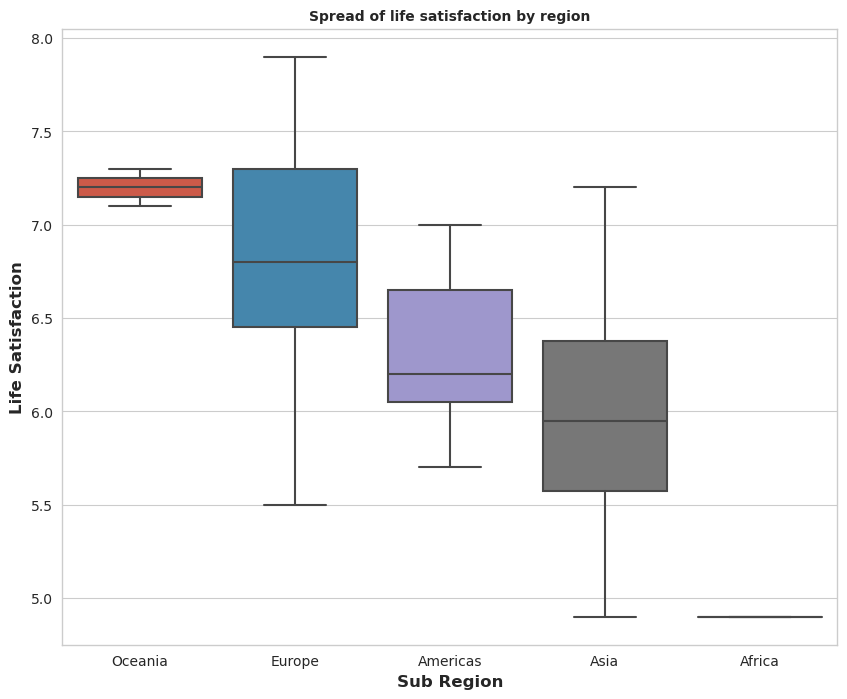

In [224]:
#how does life satisfaction differ by region
sns.set_style('whitegrid')
fig, ax  = plt.subplots(1,1,figsize = (10,8))

sns.boxplot(data=df  , x='sub_region' , y = 'life_satisfaction_score',  ax = ax);
ax.set_xlabel('Sub Region', fontweight = 'bold');
ax.set_ylabel('Life Satisfaction', fontweight = 'bold');
ax.set_title('Spread of life satisfaction by region', fontweight = 'bold', fontsize = 10);



**Some insights:**


1. The median  `life satisfaction score` is highest in the Oceania region. However, do take note that only New Zealand and Australia are here (Two countries). 

2. Since Africa only has South Africa, the boxplot created is not very informative.

3. Europe and Asia seem to have the greatest spread in their `life satisfaction scores`. Despite that, Europe's median is second only to Oceania.




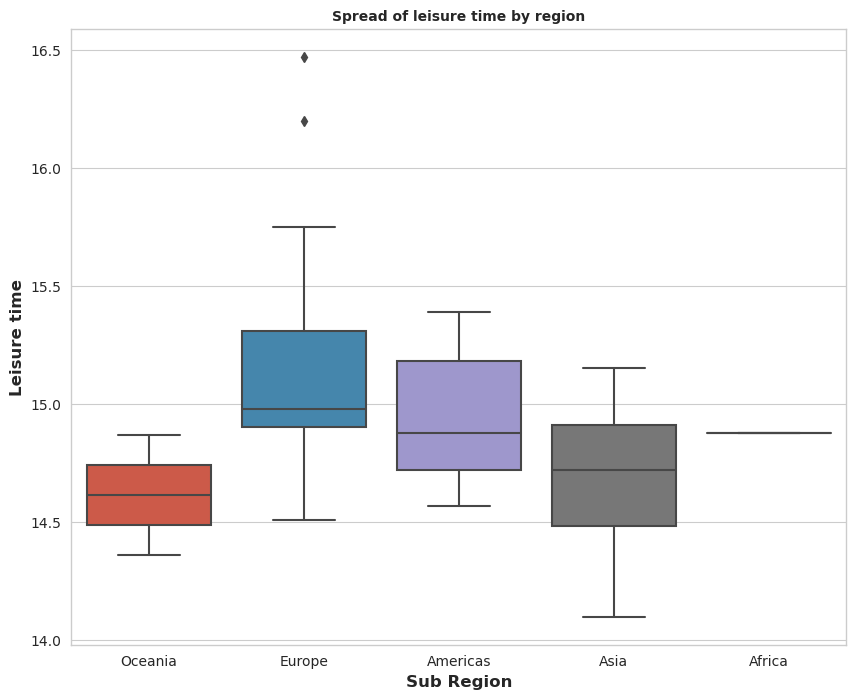

In [225]:
#How does leisure timne differ by region?

sns.set_style('whitegrid')
fig, ax  = plt.subplots(1,1,figsize = (10,8))

sns.boxplot(data=df  , x='sub_region' , y = 'leisure_time',  ax = ax);
ax.set_xlabel('Sub Region', fontweight = 'bold');
ax.set_ylabel('Leisure time', fontweight = 'bold');
ax.set_title('Spread of leisure time by region', fontweight = 'bold', fontsize = 10);



European countries have the **highest hours** of `leisure time` per day in the dataset, followed by the Americas. The boxplot measures the spread of the data and the whiskers are of length `1.5*IQR` wher IQR refers to the inter quartile range. Notice that there are two data points theat have on average more than 16.0 hours of leisure per day in the dataset.

I wanted to know what are these two countries and their life satisfaction.



In [226]:
df.loc[(df.sub_region == 'Europe') & (df.leisure_time > 16), ['country', 'leisure_time','life_satisfaction_score']]

,country,leisure_time,life_satisfaction_score
11,France,16.20,6.7
18,Italy,16.47,6.5


Those two outliers are France and Italy. They do boast fairly high `life satisfaction` but they are not that high. Other factors may have taken into play. With that in mind, the correlation matrix below entails the various relationships between feautures.

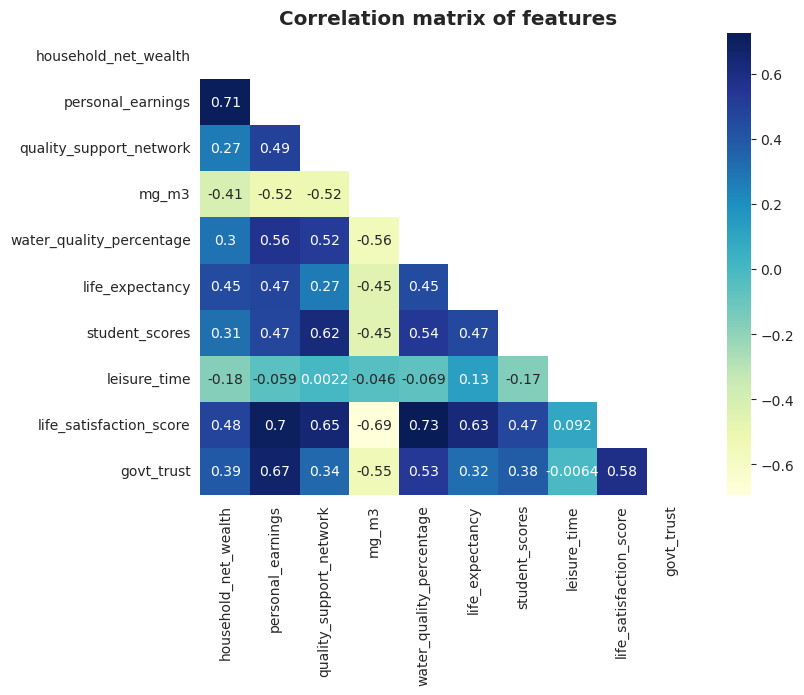

In [227]:

# Making a mask to simplify the figure.
mask = np.triu(np.ones_like(df.corr()))

fig, ax = plt.subplots(1,1, figsize = (8,6))
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True, mask=mask, ax = ax)

ax.set_title("Correlation matrix of features", fontweight = 'bold');

**Some insights:**

1. `Leisure time` does not correlate well with `life satisfaction` (0.092). This was surprising to me.

2. Environmental factors (`water quality` and `carbon dioxide emissions`) correlate well with life satisfaction. It looks like cleaner air and water is important for happiness!

3. Some factors (`personal earnings` and `quality support network`), which can be attributed to the work environment or culture in the country country, correlate well with life satisfaction.

4. `Student scores` correlate well with `quality support network`, which may suggest that a high-quality support network would lead to better performance in school.

5. Government trust actually correlates somewhat with personal earnings, water quality, and life satisfaction. This may mean that since the government achieves certain good result (especially with regards to people's earnings and water quality), the more likely it is for its people to trust them. The vice-versa to me is possible; though I think it is less likely. 

6. Finally, `life expectancy` correlate well with `life satisfaction`. This may indicate that a happier a country can make its citizens, the longer the citizens live.


Some plots to show the highly-correlated realtionships are coded below.



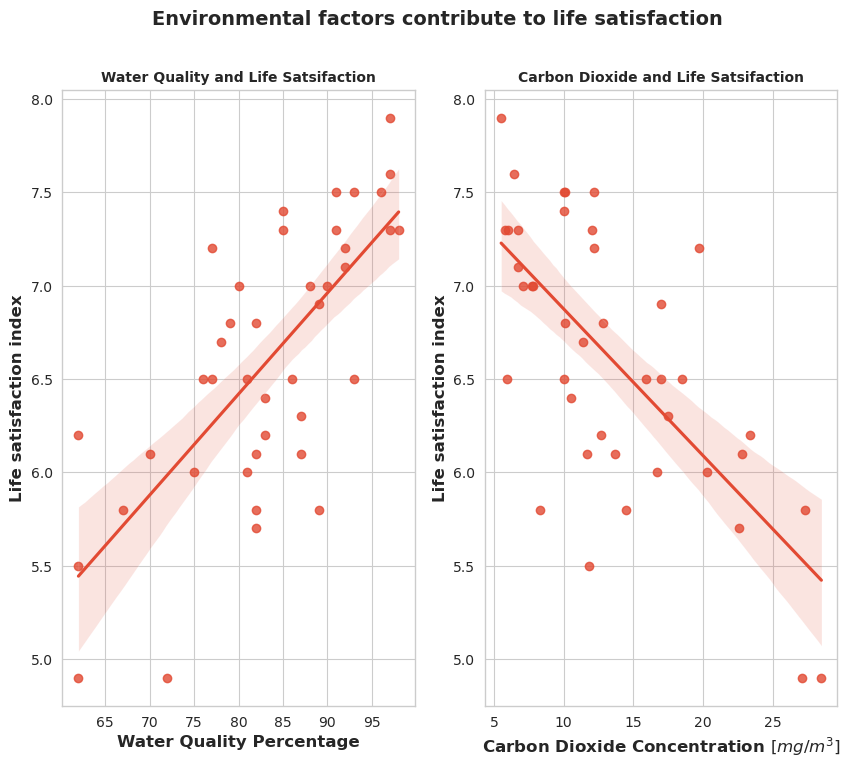

In [228]:
#Plot of environemental factors to life_satisfaction_score
sns.set_style('whitegrid')
fig, ax  = plt.subplots(1,2,figsize = (10,8))

sns.regplot(data=df  , x='water_quality_percentage' , y = 'life_satisfaction_score',  ax = ax[0])
ax[0].set_xlabel('Water Quality Percentage', fontweight = 'bold');
ax[0].set_ylabel('Life satisfaction index', fontweight = 'bold');
ax[0].set_title('Water Quality and Life Satsifaction', fontweight = 'bold', fontsize = 10);

sns.regplot(data=df  , x='mg_m3' , y = 'life_satisfaction_score',  ax = ax[1])
ax[1].set_xlabel(r'Carbon Dioxide Concentration $[mg/m^3]$', fontweight = 'bold');
ax[1].set_ylabel('Life satisfaction index', fontweight = 'bold');
ax[1].set_title('Carbon Dioxide and Life Satsifaction', fontweight = 'bold', fontsize = 10);

fig.suptitle('Environmental factors contribute to life satisfaction', fontsize=14, fontweight = 'bold');

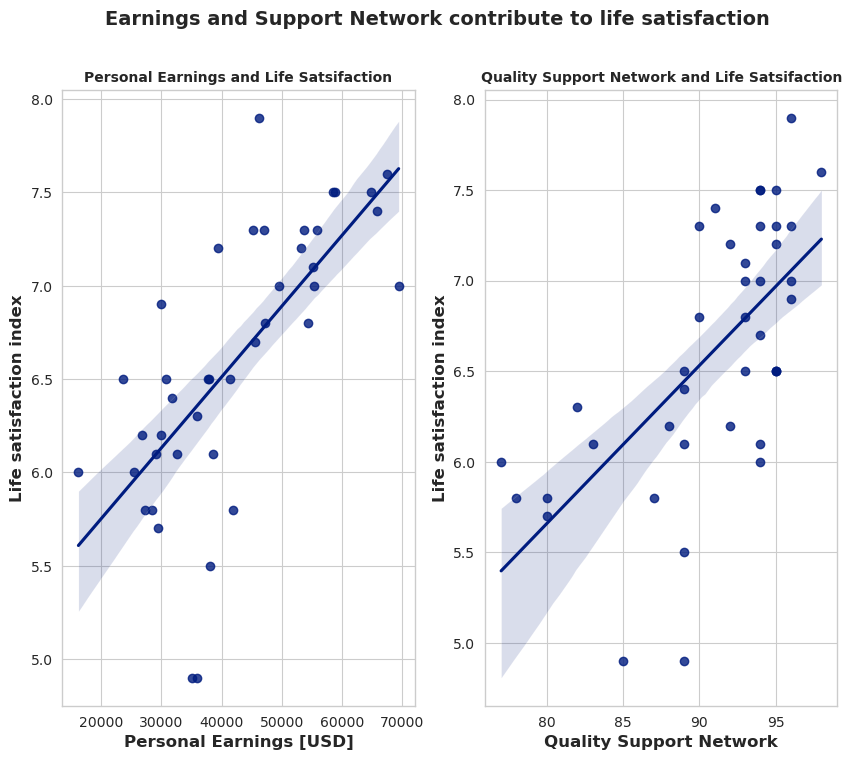

In [229]:
#Plot of environemental factors to life_satisfaction_score
sns.set_style('whitegrid')
sns.set_palette("dark")
fig, ax  = plt.subplots(1,2,figsize = (10,8))

sns.regplot(data=df  , x='personal_earnings' , y = 'life_satisfaction_score',  ax = ax[0])
ax[0].set_xlabel('Personal Earnings [USD]', fontweight = 'bold');
ax[0].set_ylabel('Life satisfaction index', fontweight = 'bold');
ax[0].set_title('Personal Earnings and Life Satsifaction', fontweight = 'bold', fontsize = 10);

sns.regplot(data=df  , x='quality_support_network' , y = 'life_satisfaction_score',  ax = ax[1],)
ax[1].set_xlabel('Quality Support Network', fontweight = 'bold');
ax[1].set_title('Quality Support Network and Life Satsifaction', fontweight = 'bold', fontsize = 10);
ax[1].set_ylabel('Life satisfaction index', fontweight = 'bold');

fig.suptitle('Earnings and Support Network contribute to life satisfaction', fontsize=14, fontweight = 'bold');

Looks good! The `carbon dioxide concentration` seem to go down drastically with `life satisfaction`. I think the `carbon dioxide concentration` is probably affecting the health of the citizens of the countries, and as their life is healthier the more satisfied they are with their life. In addition, the `carbon dioxide concentration` seems to correlate well with the `water quality of the country`. To me this suggests that countries with higher life satisfaction seem to handle environmnetal issues fairly well using for instance various policies to save the environment. I also think that as `water quality` and `carbon dioxide concentration` are correlated, it seems like governments that do well on one part do well on the other too.

Below is the plot of the `water quality` with `carbon dioxide concentration`.

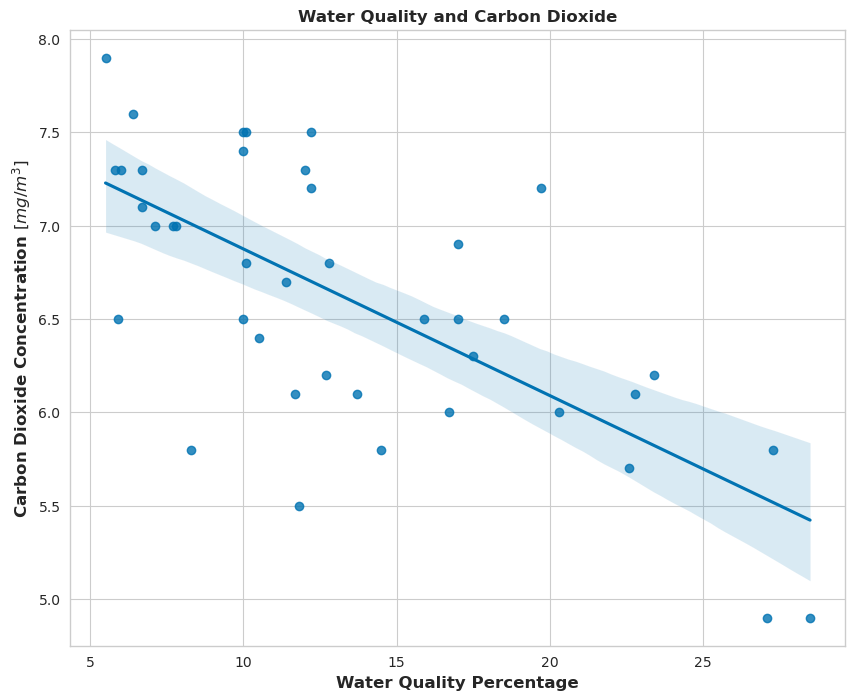

In [232]:
sns.set_style('whitegrid')
sns.set_palette("colorblind")
fig, ax  = plt.subplots(1,1,figsize = (10,8))

sns.regplot(data=df  , x='mg_m3' , y = 'life_satisfaction_score',  ax = ax)
ax.set_xlabel('Water Quality Percentage', fontweight = 'bold');
ax.set_ylabel(r'Carbon Dioxide Concentration $[mg/m^3]$', fontweight = 'bold');
ax.set_title('Water Quality and Carbon Dioxide', fontweight = 'bold', fontsize = 12);

Though what was surprising to me was that the `life expectancy` variable seem to correlate only moderately with those two factors. Some other factors may be at play for that, such as the diet, drinking habits, and possibly ease of attaining healthcare. 